The experiment configuration is already present in a JSON file in the example_configs directory.  It imagines an experiment in which there were 5 stim periods of duration 10 seconds, starting at seconds 20, 40, 60, 80, and 100, and for each of those stim periods there were 10 stim events, starting every second. We simulate a single neuron (unit) from a single animal, and add its spikes to the experiment config file (in a real analysis, you'd likely be reading the spikes from data files.) 

In [4]:
# demo/k_onda_demo.ipynb

import json, logging, random
from pathlib import Path

from k_onda.devtools import find_project_root
from k_onda.main import run_pipeline

logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

PROJECT_ROOT = find_project_root()
CONFIG_PATH = Path(f"{PROJECT_ROOT}/k_onda/example_configs/config.json")

DURATION_SECONDS = 100
FIRING_RATE_SPS = 10
NUM_SPIKES = DURATION_SECONDS * FIRING_RATE_SPS
random.seed(42)
spike_times = sorted(random.uniform(0, DURATION_SECONDS) for _ in range(NUM_SPIKES))

with open(CONFIG_PATH, "r+", encoding="utf-8") as f:
    config = json.load(f)
    unit = config["animals"][0]["units"]["good"][0]
    unit["spike_times"] = [round(t, 4) for t in spike_times]
    unit["firing_rate"] = round(len(spike_times) / DURATION_SECONDS, 2)
    f.seek(0)
    json.dump(config, f, indent=2)
    f.truncate()

Now we configure the calculation we are going to perform and the plot we are going to make. The following configuration averages first over events, then over periods, to produce a peristimulus time histogram.

In [5]:
psth_plot = {
    'plot_type': 'psth',
    'section': {
        'attr': 'calc',
        'aesthetics': {
            'ax': {'border': {'top': {'visible': 'FFF'}, 'right': {'visible': 'FFF'}}},
            'default': {
                'marker': {'color': '#1f77b4'},
                'indicator': {'type': 'patch', 'when': (0, .05)}}},
        'label': {'x_bottom': {'text': 'Seconds'},
                  'y_left': {'text': 'Firing Rate (Spikes per Second)'},
                  'title': {'text': 'Peristimulus Time Histogram', 'kwargs': {'y': 1.05}}},
        'divisions': [{'divider_type': 'period_type', 'members': ['stim']}]
    }
}

PSTH_OPTS = {
    
    'procedure': 'make_plots',
    'plot_spec': psth_plot,
    'write_opts': './psth',
    'calc_opts': {'kind_of_data': 'spike', 'calc_type': 'firing_rates',
                  'base': 'event', 'bin_size': .01, 
                  'periods': {'stim': {'period_pre_post': (1, 0), 'event_pre_post': (.05, 1)}} 
    }}

Now we run the pipeline.  The grey patch represents the imagined duration of the simulus (.05s).

In [7]:
run_pipeline(config_file=CONFIG_PATH, opts=PSTH_OPTS)

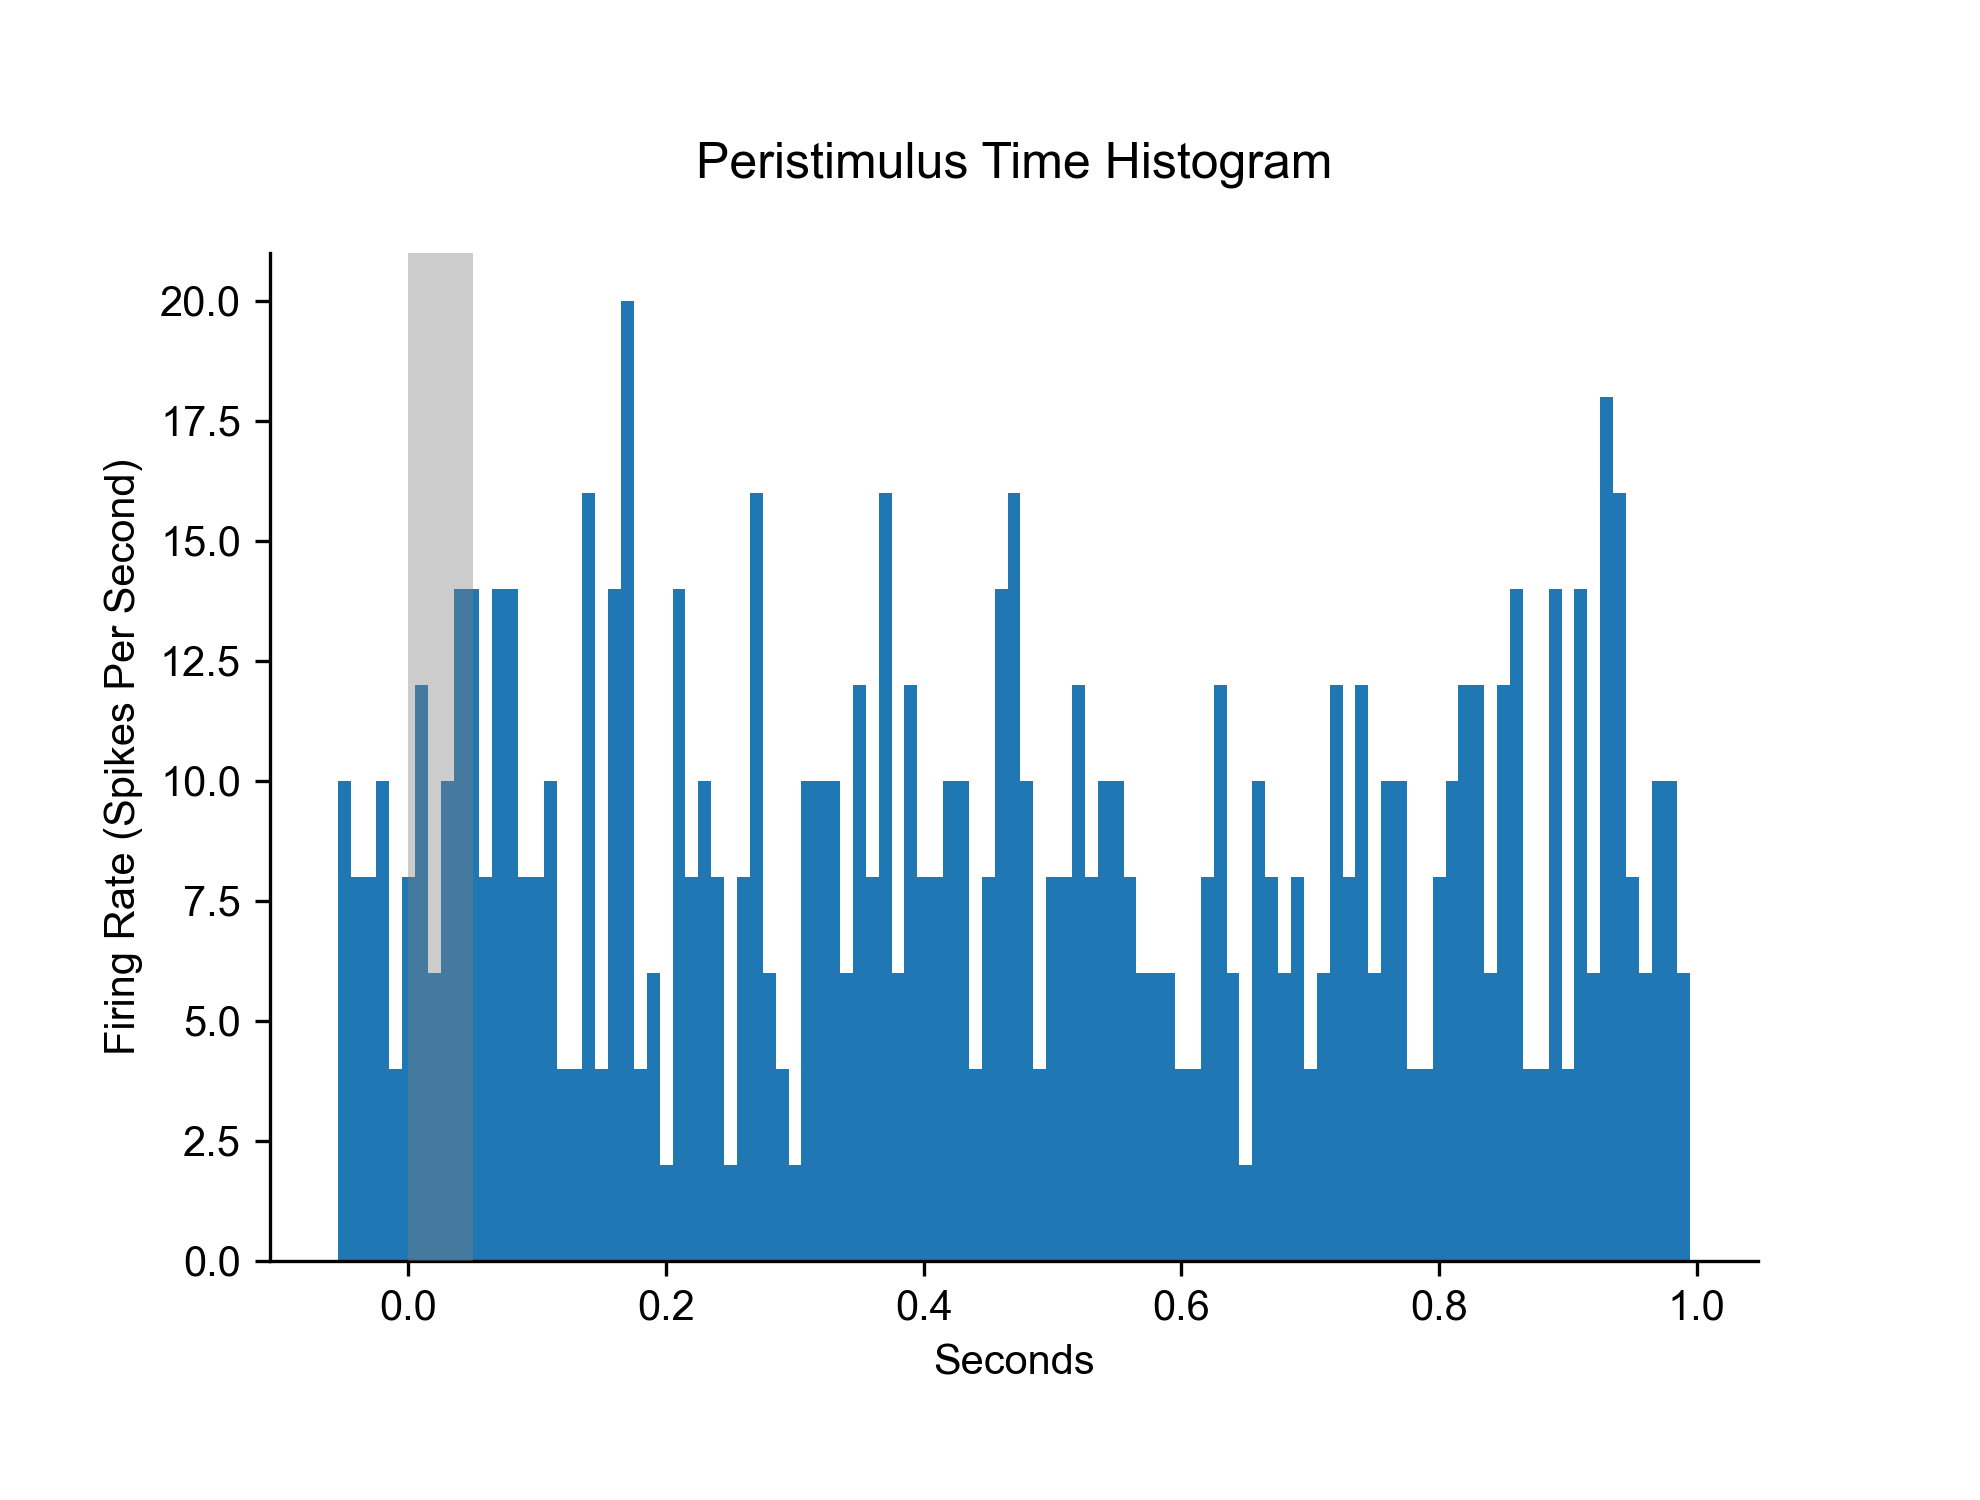

In [8]:
from IPython.display import Image, display
from k_onda.devtools import find_project_root

ROOT = find_project_root()
img_path = ROOT / "demo" / "psth.png" 
display(Image(filename=str(img_path)))
